In [0]:
# !pip install pycm

In [0]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
%autoreload 2

from IPython import display
import copy

# from utils import Logger

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms,datasets, models
from torch.utils.data import ConcatDataset
from torchvision.transforms import ToPILImage
import torchvision
from torchvision.utils import make_grid
from torch.autograd import Variable
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import matplotlib.animation as animation
from IPython.display import HTML

In [0]:
DATA_FOLDER = './MNIST'
batch_size=100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_size=64

In [0]:
randn=123
torch.manual_seed(randn)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(randn)
np.random.seed(randn)

In [0]:
img_transformations = transforms.Compose(
    [transforms.Resize(image_size),
     transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
destination=DATA_FOLDER+'/dataset'
dataset=datasets.MNIST(root=destination, train=True, transform=img_transformations, download=True)

In [0]:
def image_grid(input_images):
    input_images=input_images.cpu()
    input_images = np.array([.5, .5, .5]) * input_images.numpy().transpose((1, 2, 0)) + np.array([.5, .5, .5])
    plt.grid(False)
    plt.imshow(np.clip(input_images, 0, 1))
    
def show_grid(loader):    
    def image_grid(input_images):
        input_images = np.array([.5, .5, .5]) * input_images.numpy().transpose((1, 2, 0)) + np.array([.5, .5, .5])
        plt.grid(False)
        plt.imshow(np.clip(input_images, 0, 1))

    images, labels = next(iter(loader))
    image_grid(make_grid(images))

In [0]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Num batches
num_batches = len(data_loader)

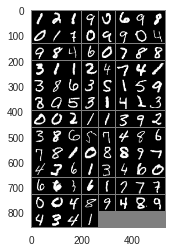

In [0]:
show_grid(data_loader)

In [0]:
def get_input_size(x):
  images,_=next(iter(x))
  return(images.shape[-1]*images.shape[-2])
def get_channel_size(x):
  images,_=next(iter(x))
  return(images.shape[1])

In [0]:
def get_hidden_sizes(input_size,hidden_sizes,output_size):
  hidden_sizes=np.insert(hidden_sizes,0,input_size)
  hidden_sizes=np.append(hidden_sizes,output_size)
  print(hidden_sizes)
  return(hidden_sizes)

In [0]:
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

In [0]:
class Discriminator(torch.nn.Module):

    def __init__(self,hidden_sizes):
        super(Discriminator, self).__init__()
        self.input_size=hidden_sizes[0]
        self.output_size=hidden_sizes[-1]

        hidden_layers = nn.ModuleList()
        
        for k in range(len(hidden_sizes)-2):
          hidden_layers.append(nn.Conv2d(hidden_sizes[k], hidden_sizes[k+1], 4, 2, 1, bias=False))

          if((k<len(hidden_sizes)-1)):
            if(k>0):
              hidden_layers.append(nn.LeakyReLU(0.2, inplace=True))
              hidden_layers.append(nn.Dropout2d(0.25))
              hidden_layers.append(nn.BatchNorm2d(hidden_sizes[k+1]))
            elif(k==0):
              hidden_layers.append(nn.LeakyReLU(0.2, inplace=True))
              hidden_layers.append(nn.Dropout2d(0.25))
              
        hidden_layers.append(nn.Conv2d(hidden_sizes[-2], hidden_sizes[-1]*100, 4, 1, 0, bias=False))
        hidden_layers.append(nn.Dropout2d(p=0.5))
        hidden_layers.append(Flatten())
        hidden_layers.append(nn.Linear(hidden_sizes[-1]*100,hidden_sizes[-1]*100))
        hidden_layers.append(nn.Dropout(0.5))
        hidden_layers.append(nn.Linear(hidden_sizes[-1]*100,hidden_sizes[-1]))
        hidden_layers.append(nn.Sigmoid())
        self.net=nn.Sequential(*hidden_layers)
        
 
    def forward(self, x):
      return(self.net(x))


In [0]:
class Generator(torch.nn.Module):

    def __init__(self,hidden_sizes):
        super(Generator, self).__init__()
        self.input_size=hidden_sizes[0]
        self.output_size=hidden_sizes[-1]

        hidden_layers = nn.ModuleList()
        
        for k in range(len(hidden_sizes)-2):

          if((k<len(hidden_sizes)-1)):
              stride=lambda x: 2 if x > 0 else 1
              padding=lambda x: 1 if x > 0 else 0
              hidden_layers.append(nn.ConvTranspose2d(hidden_sizes[k], hidden_sizes[k+1], 4, stride(k) ,padding(k), bias=False))
              hidden_layers.append(nn.BatchNorm2d(hidden_sizes[k+1]))
              hidden_layers.append(nn.ReLU(inplace=True))
              
        hidden_layers.append(nn.ConvTranspose2d(hidden_sizes[-2], hidden_sizes[-1], 4,stride(k) ,padding(k), bias=False))  
        hidden_layers.append(nn.Tanh())
        self.net=nn.Sequential(*hidden_layers)
        
 
    def forward(self, x):
      return(self.net(x))


In [0]:
hidden_sizes=get_hidden_sizes(get_channel_size(data_loader),[i*image_size for i in [1,2,4,8]],1)
dis_net=Discriminator(hidden_sizes).to(device)
# dis_net.apply(weights_init)


hidden_sizes=get_hidden_sizes(batch_size,[i*image_size for i in [8,4,2,1]],get_channel_size(data_loader))
gen_net=Generator(hidden_sizes).to(device)
# gen_net.apply(weights_init)




snap_every=10
print_every=100
loop_n=1
epochs=200
steps=0
dis_loss_all=[]
gen_loss_all=[]
dis_loss_fakes_all=[]
dis_loss_images_all=[]
dis_optimizer = optim.Adam(dis_net.parameters(), lr=0.01,betas=[0.5,0.99])#betas=[0.5,0.99]
gen_optimizer = optim.Adam(gen_net.parameters(), lr=0.01,betas=[0.5,0.99])#,weight_decay=0.05)##),betas=[0.5,0.99]
criterion  = nn.BCELoss()
snaps=[]
threshold=np.linspace(0.7,0.01,len(data_loader))
patience=100
sd=6
test_noise=Variable(torch.randn(100, 100, 1, 1)).to(device)
skip_dis=False
skip_gen=False

for e in range(epochs):
    for j,(images,labels) in enumerate(data_loader):
      steps+=1
      dis_net.train()
      dis_optimizer.zero_grad()
      images=Variable(images).to(device)
      dis_targets=Variable(torch.ones(images.shape[0],1),requires_grad=False).to(device)
      noise=Variable(torch.randn(images.shape[0], 100, 1, 1)).to(device)
      gen_net.eval()
      fake_images=gen_net(noise).detach()
      fake_targets=Variable(torch.zeros(fake_images.shape[0],1),requires_grad=False).to(device)

      #train Discriminator on real images
      dis_output_images=dis_net(images).view(-1,1)
      dis_loss_images=criterion(dis_output_images,dis_targets)

      #train Discriminator on fake images
      dis_output_fakes=dis_net(fake_images).view(-1,1)
      dis_loss_fakes=criterion(dis_output_fakes,fake_targets)     

      dis_loss=dis_loss_fakes+dis_loss_images
      dis_loss_fakes_all.append(dis_loss_fakes.item())
      dis_loss_images_all.append(dis_loss_images.item())
      dis_loss_all.append(dis_loss.item())
      if(not skip_dis or dis_loss_images.item()>0.4 or dis_loss_fakes.item()>0.4):
#         print("backpropagate discriminator",'dis_loss: ',round(dis_loss.item(),sd),'fake:',round(dis_loss_fakes.item(),sd),'real:',round(dis_loss_images.item(),sd))
        dis_loss.backward()
        dis_optimizer.step()

      
      for i in range(0,loop_n,1):
        #train generator
        gen_optimizer.zero_grad()      
        noise=Variable(torch.randn(images.shape[0], 100, 1, 1)).to(device)
        gen_net.eval()
        fake_images=gen_net(noise).detach()
        fake_targets=Variable(torch.ones(fake_images.shape[0],1),requires_grad=False).to(device)
        dis_net.eval()
        #feed the Discriminator fake images created by the generator, Discriminator is in eval mode
        gen_output_fakes=dis_net(fake_images).view(-1,1)
        gen_net.train()
        gen_loss=criterion(gen_output_fakes,fake_targets)
        if (not skip_gen):
          gen_loss.backward()
        gen_loss_all.append(gen_loss.item())
        if (i>0):
          dis_loss_all.append(dis_loss.item())
          dis_loss_fakes_all.append(dis_loss_fakes.item())
          dis_loss_images_all.append(dis_loss_images.item())
        gen_optimizer.step()
        
        if(gen_loss.item()<dis_loss_fakes.item()):
          skip_dis=True
          break
      if(e+1>=30):
        ratio=round(gen_loss.item()/dis_loss_images.item(),3)
        if(ratio<1):
          loop_n=1
          skip_dis=False
        elif(ratio<20 and ratio>1):
          loop_n=round(ratio)*200
          skip_dis=True
        else:
          loop_n=5000
          skip_dis=True       
  #       if(len(gen_loss_all)>patience):
  #         if(all([True if round(target,4)==round(gen_loss_all[-1],4) else False for target in gen_loss_all[-1*patience:-2] ])):
  #           print('patience reached')
  #           skip_dis=False
  #       if(ratio>40):
  #         loop_n=1
  #         skip_dis=False
        print(ratio,' ',loop_n)
      if(steps%print_every==0):
        print(e,' ',steps,'dis_loss: ',round(dis_loss.item(),sd),'fake:',round(dis_loss_fakes.item(),sd),'real:',round(dis_loss_images.item(),sd),' ','gen_loss: ',round(gen_loss.item(),sd))
#       if((steps)%len(data_loader)==0):
      if(((steps)%snap_every==0)):
        gen_net.eval()
        with torch.no_grad():
          test_fake_images=gen_net(test_noise).cpu()
          snaps.append(vutils.make_grid(test_fake_images, padding=5, normalize=True))
        gen_net.train()
      
      
      

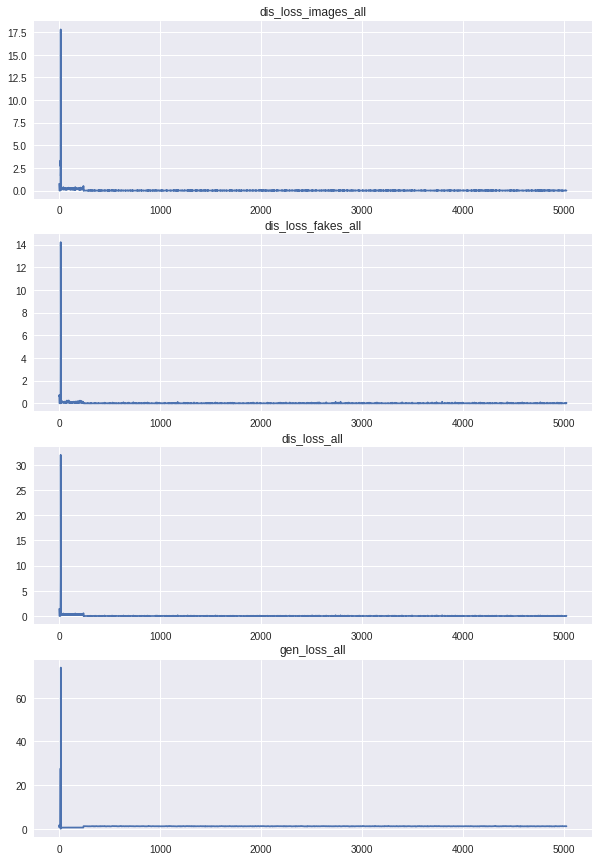

In [0]:
train_results=[dis_loss_images_all,dis_loss_fakes_all,dis_loss_all,gen_loss_all]
titles=['dis_loss_images_all','dis_loss_fakes_all','dis_loss_all','gen_loss_all']
fig = plt.figure(figsize=(10,15))
for i,data in enumerate(train_results):    
    plt.subplot(4,1, i+1)
    plt.plot(data)
    plt.title(titles[i])

In [0]:
all([True if round(target,4)==round(gen_loss_all[-1],4) else False for target in gen_loss_all[-1*patience:-2] ])

In [0]:
fig = plt.figure(figsize=(5,5))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in snaps]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True);
plt.close()
HTML(ani.to_html5_video())


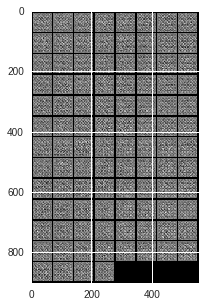

In [0]:
fig = plt.figure(figsize=(5,5))
pic=vutils.make_grid(test_fake_images, padding=5, normalize=True)
plt.imshow(np.transpose(pic,(1,2,0)))